### Calculando a similaridade das frases de pacientes com o mapa de conhecimento

In [1]:
import numpy as np
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
!python -m spacy download pt_core_news_md

     ---------------------------------------- 0.0/42.4 MB ? eta -:--:--
     -------- ------------------------------- 9.4/42.4 MB 49.1 MB/s eta 0:00:01
     --------------- ----------------------- 16.8/42.4 MB 42.3 MB/s eta 0:00:01
     --------------------- ----------------- 23.6/42.4 MB 39.3 MB/s eta 0:00:01
     ---------------------------- ---------- 31.5/42.4 MB 43.4 MB/s eta 0:00:01
     --------------------------------------  41.9/42.4 MB 42.4 MB/s eta 0:00:01
     --------------------------------------- 42.4/42.4 MB 36.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importação do mapa de conhecimento.

In [3]:
df_conhecimento = pd.read_csv('mapa_conhecimento.csv')
df_conhecimento.head()

,sintoma,diagnostico
0,Dor ou pressão intensa no peito,Infarto
1,Suor frio repentino,Infarto
2,Falta de ar súbita,Infarto
3,Náusea ou vômito associado a dor,Infarto
4,Dor irradiando para braço ou mandíbula,Infarto


Importação das frases de sintomas de pacientes.

In [4]:
df_sintomas = pd.read_csv('../dataset/sintomas_doencas_cardiacas.csv')
df_sintomas.head()

,frase,diagnostico,risco
0,Sinto uma dor aguda no peito que surge ao subi...,Angina,Baixo Risco
1,"Há dois dias, dor forte no peito irradia para ...",Infarto,Alto Risco
2,"Estou exausto o dia todo, mesmo sem esforço, e...",Insuficiência Cardíaca,Baixo Risco
3,Meu coração acelera de repente durante reuniõe...,Arritmia,Alto Risco
4,"Pressão no peito ao estressar no trabalho, ali...",Angina,Baixo Risco


Importação do spaCy em português.

In [5]:
nlp = spacy.load("pt_core_news_md")

Função para calcular a similaridade utilizando spaCy.

In [6]:
def calculate_similarity(texto1, texto2):
    doc1 = nlp(texto1)
    doc2 = nlp(texto2)
    return doc1.similarity(doc2)

### Teste com frases do dataset

In [7]:
calculate_similarity(df_sintomas.loc[0, 'frase'], df_conhecimento.loc[0, 'sintoma'])

0.7145339250564575

Testa frases de pacientes com todos os sintomas presentes no `mapa_conhecimento.csv`. A frase com maior similaridade será o possível diagnóstico.

In [8]:
predictions = []
for _, row in df_sintomas.iterrows():
    frase_paciente = row['frase']
    best_match = None
    highest_similarity = 0.0
    
    for _, conhecimento in df_conhecimento.iterrows():
        sintoma = conhecimento['sintoma']
        similarity = calculate_similarity(frase_paciente, sintoma)
        
        if similarity > highest_similarity:
            highest_similarity = similarity
            best_match = conhecimento['diagnostico']
    predictions.append((frase_paciente, best_match, highest_similarity))


In [9]:
df_predictions = pd.DataFrame(predictions, columns=['frase', 'diagnostico_predito', 'similaridade'])
df_predictions.head()

,frase,diagnostico_predito,similaridade
0,Sinto uma dor aguda no peito que surge ao subi...,Arritmia,0.716142
1,"Há dois dias, dor forte no peito irradia para ...",Arritmia,0.694121
2,"Estou exausto o dia todo, mesmo sem esforço, e...",Angina,0.645999
3,Meu coração acelera de repente durante reuniõe...,Insuficiência Cardíaca,0.784750
4,"Pressão no peito ao estressar no trabalho, ali...",Angina,0.676632


### Avaliação do método de verificação de similaridade das frases

In [10]:
labels = np.unique(df_conhecimento['diagnostico'])
y_true, y_pred = df_sintomas['diagnostico'], df_predictions['diagnostico_predito']

In [11]:
acc = accuracy_score(y_true, y_pred)
print(f"Acurácia de {acc*100:.2f} %")

Acurácia de 27.00 %


In [12]:
print(classification_report(y_true, y_pred))

                        precision    recall  f1-score   support

                Angina       0.26      0.38      0.31        26
              Arritmia       0.20      0.16      0.18        25
               Infarto       0.47      0.35      0.40        26
Insuficiência Cardíaca       0.17      0.17      0.17        23

              accuracy                           0.27       100
             macro avg       0.28      0.27      0.27       100
          weighted avg       0.28      0.27      0.27       100



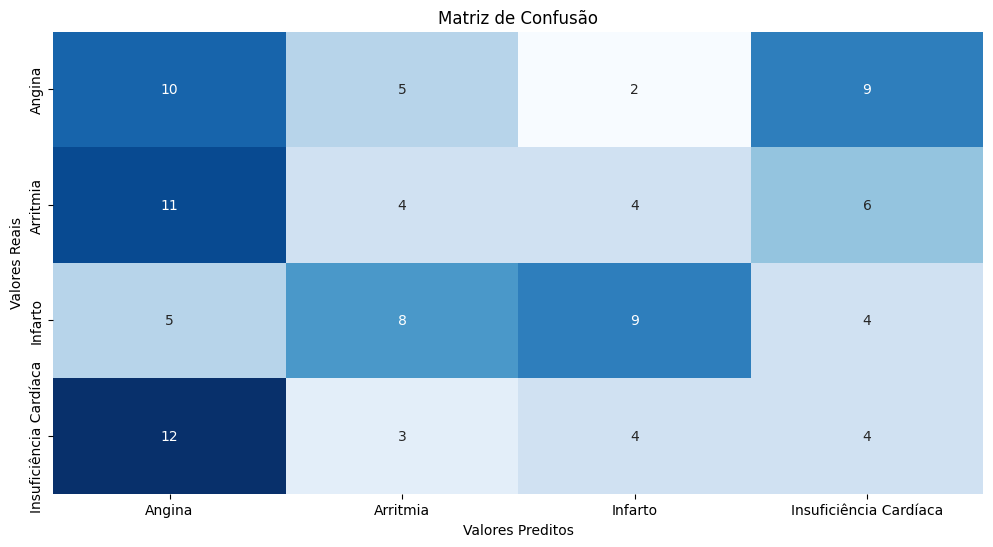

In [13]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()